In [1]:
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/train.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/valid.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/test.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [2]:
# Import OS module
import os

# Imports
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks, layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Notebook magic
%matplotlib inline

In [3]:
!nvidia-smi

Mon Oct  9 12:45:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# Configure variables for Transfer learning
image_size = 224
target_size = (image_size, image_size)
input_shape = (image_size, image_size, 3)
grid_shape = (1, image_size, image_size, 3)

batch_size = 32

In [5]:
train_dir = "/content/train"
test_dir = "/content/test"
valid_dir = "/content/valid"

In [6]:
# Define augmentations for train dataset and read the images
train_aug = ImageDataGenerator(
    # Rescale
    rescale=1/255.0,
    # Filling for W/H shift
    fill_mode="nearest",
    # Width and Height shift
    width_shift_range=0.2,
    height_shift_range=0.2,
    # Random zooms
    zoom_range=0.2,
    # Random Shearing aug
    shear_range=0.2,
)

# Read data from directory
train_data = train_aug.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode="categorical"
)

Found 70295 images belonging to 38 classes.


In [7]:
cats = list(train_data.class_indices.keys())

In [8]:
# Augmentations for test data
test_aug = ImageDataGenerator(
    # Rescale
    rescale=1/255.0
)

# Read data from directory
test_data = test_aug.flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode="categorical"
)

# valid data
valid_aug = ImageDataGenerator(
    # Rescale
    rescale=1/255.0
)

# Read data from directory
valid_data = test_aug.flow_from_directory(
    valid_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode="categorical"
)

Found 33 images belonging to 1 classes.
Found 17572 images belonging to 38 classes.


In [9]:
# Load the base model
mbnet_v2 = keras.applications.MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=input_shape
)

# Stop from being trainable
mbnet_v2.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [10]:
# Define the layers
inputs = keras.Input(shape=input_shape)

# Get the layer
x = mbnet_v2(inputs, training = False)

# Stack layers further
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(len(cats), activation="softmax")(x)

# Combine the model
model = Model(inputs=inputs, outputs=x)

# Summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 38)                48678     
                                                                 
Total params: 2306662 (8.80 MB)
Trainable params: 48678 (190.

In [11]:
# Compile
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Define callbacks to use
early_stopping_cb = callbacks.EarlyStopping(monitor="loss", patience=3)

In [12]:
# Num epochs
epochs = 30

# Train model
history = model.fit(
    train_data,
    epochs=epochs,
    steps_per_epoch=200,
    validation_data=valid_data,
    callbacks=[early_stopping_cb]
)

Epoch 1/30
200/200 [==============================] - 136s 622ms/step - loss: 1.6747 - accuracy: 0.5619 - val_loss: 0.7982 - val_accuracy: 0.7923
Epoch 2/30
200/200 [==============================] - 119s 597ms/step - loss: 0.7560 - accuracy: 0.7862 - val_loss: 0.5548 - val_accuracy: 0.8465
Epoch 3/30
200/200 [==============================] - 115s 575ms/step - loss: 0.5935 - accuracy: 0.8259 - val_loss: 0.4440 - val_accuracy: 0.8739
Epoch 4/30
200/200 [==============================] - 122s 613ms/step - loss: 0.4832 - accuracy: 0.8589 - val_loss: 0.3987 - val_accuracy: 0.8841
Epoch 5/30
200/200 [==============================] - 122s 608ms/step - loss: 0.4370 - accuracy: 0.8672 - val_loss: 0.3636 - val_accuracy: 0.8909
Epoch 6/30
200/200 [==============================] - 114s 570ms/step - loss: 0.4161 - accuracy: 0.8670 - val_loss: 0.3638 - val_accuracy: 0.8880
Epoch 7/30
200/200 [==============================] - 113s 565ms/step - loss: 0.4000 - accuracy: 0.8789 - val_loss: 0.3149 -

In [14]:
model.evaluate(valid_data)

550/550 [==============================] - 43s 77ms/step - loss: 0.2462 - accuracy: 0.9206


[0.24620495736598969, 0.9206123352050781]

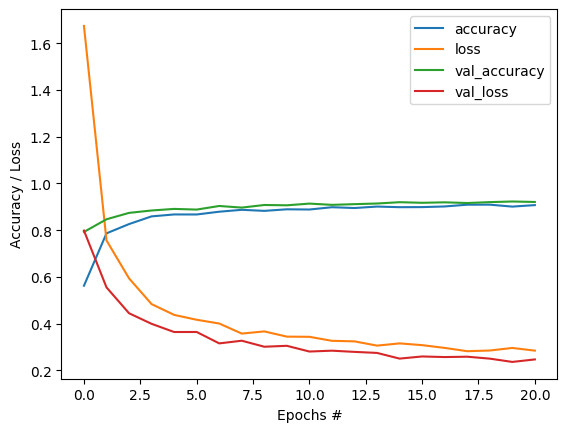

In [15]:
# Plotting
hist = history.history

# Plot accuracy and loss
plt.plot(hist["accuracy"], label="accuracy")
plt.plot(hist["loss"], label="loss")

if "val_accuracy" in hist and "val_loss" in hist:
    plt.plot(hist["val_accuracy"], label="val_accuracy")
    plt.plot(hist["val_loss"], label="val_loss")

# Add the labels and legend
plt.ylabel("Accuracy / Loss")
plt.xlabel("Epochs #")
plt.legend()

# Finally show the plot
plt.show()

In [16]:
model.save("plant_disease_detection.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
import json

from IPython.display import FileLink

# Link the files
FileLink("./plant_disease_detection.h5")

/content/plant_disease_detection.h5

In [18]:
# Dump the categories
with open("categories.json", "w") as file:
  json.dump(train_data.class_indices, file)

# Link categories JSON
FileLink("categories.json")

/content/categories.json

In [31]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

image_path = '/content/test/test_data/TomatoHealthy1.JPG'
img = image.load_img(image_path, target_size=(224, 224))  # Adjust target_size as needed
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)


In [32]:
predictions = model.predict(img_array)

1/1 [==============================] - 0s 23ms/step


In [33]:
class_mapping = {
    0: 'Apple Scab',
    1: 'Apple Black Rot',
    2: 'Apple Rust',
    3: 'Apple Healthy',
    4: 'Blueberry Healthy',
    5: 'Cherry (including sour) Powdery mildew',
    6: 'Cherry (including sour) healthy',
    7: 'Corn (maize) Cercospora leaf spot Gray leaf spot',
    8: 'Corn (maize) Common rust',
    9: 'Corn (maize) Northern Leaf Blight',
    10: 'Corn (maize) Healthy',
    11: 'Grape Black Rot',
    12: 'Grape Esca (Black Measles)',
    13: 'Grape Leaf blight (Isariopsis Leaf Spot)',
    14: 'Grape Healthy',
    15: 'Orange Haunglongbing (Citrus greening)',
    16: 'Peach Bacterial Spot',
    17: 'Peach Healthy',
    18: 'Pepper Bell Bacterial Spot',
    19: 'Pepper Bell Healthy',
    20: 'Potato Early Blight',
    21: 'Potato Late Blight',
    22: 'Potato Healthy',
    23: 'Raspberry Healthy',
    24: 'Soyabean Healthy',
    25: 'Squash Powdery Mildew',
    26: 'Strawberry Leaf Scorch',
    27: 'Strawberry Healthy',
    28: 'Tomato Bacterial Spot',
    29: 'Tomato Early Blight',
    30: 'Tomato Late Blight',
    31: 'Tomato Leaf Mold',
    32: 'Tomato Septoria leaf spot',
    33: 'Tomato Spider mites Two-spotted spider mite',
    34: 'Tomato Target Spot',
    35: 'Tomato Tomato Yellow Leaf Curl Virus',
    36: 'Tomato Tomato mosaic virus',
    37: 'Tomato Healthy',
    38: 'None',
    }

In [34]:
predicted_class_index = np.argmax(predictions)
predicted_disease_class = class_mapping.get(predicted_class_index, 'Unknown')
print("Predicted Disease Class:", predicted_disease_class)

Predicted Disease Class: Tomato Healthy
